
# Technical Test: Python and SQLAlchemy Proficiency

## Objective

This test is designed to assess your proficiency in Python programming and your understanding of Object-Relational Mapping (ORM) using SQLAlchemy. You will interact with a small database application in a Jupyter Notebook environment, showcasing your ability to manage and manipulate data effectively.

## Test Environment

The test will be conducted in a Jupyter Notebook hosted on GitHub. All necessary libraries, including SQLAlchemy, are pre-installed, and the environment is set up for you. You will work on a fork of the provided repository.

## Test Overview

You will complete a series of tasks that involve interacting with a small database application using Python and SQLAlchemy. The test will evaluate your ability to:

1. **Implement ORM Models**: Create Python classes that map to database tables using SQLAlchemy ORM, including fields, relationships, and constraints.

2. **Perform CRUD Operations**: Write Python code to perform Create, Read, Update, and Delete operations on the database using SQLAlchemy.

3. **Query Optimization**: Demonstrate your ability to write efficient queries, utilizing SQLAlchemy features to optimize database access.

4. **Handle Transactions**: Implement transaction management to ensure data integrity during complex operations.

5. **Documentation and Code Quality**: Provide clear documentation and adhere to best practices in code structure and style.

## Instructions

1. **Fork the Repository**: Start by forking the provided GitHub repository to your own account.

2. **Access the Jupyter Notebook**: Open the Jupyter Notebook in your forked repository to begin the test.

3. **Complete the Tasks**: Follow the instructions in the notebook to complete each task. Ensure your code is functional and meets the specified requirements.

4. **Use SQLAlchemy Documentation**: Refer to the [SQLAlchemy documentation](https://docs.sqlalchemy.org) as needed to assist with your implementation.

5. **Commit Your Changes**: Once you have completed the tasks, commit your changes to your forked repository.

6. **Submit Your Test**: Notify us by providing a link to your forked repository with your completed test.

## Evaluation Criteria

-  **Correctness**: The solution should meet all specified requirements and perform all operations correctly.
-  **Code Quality**: Code should be clean, well-organized, and follow Python best practices.
-  **Efficiency**: Solutions should be optimized for performance, especially in the context of database operations.
-  **Problem Solving**: Demonstrated ability to effectively solve problems and make sound design decisions.
-  **Documentation**: Clear and concise documentation that helps reviewers understand your approach and implementation.

We look forward to reviewing your work and assessing your potential to contribute to our development team.

In [ ]:
import sqlalchemy as sa

import models as m

# First, let's connect to the database
engine = sa.create_engine("sqlite:///quiz.db")
SessionMaker = sa.orm.sessionmaker(autocommit=False, autoflush=False, bind=engine)
session = SessionMaker()

In [3]:
# example query sites
sites_query = sa.select(m.Site).limit(10)
sites = list(session.execute(sites_query).scalars())
print(sites)

[<Site n°1 - GigaWatt Llama Ranch>, <Site n°2 - Sunny Side of the Moon>, <Site n°3 - River Dance Powerhouse>, <Site n°4 - Turbine Nation Offshore>, <Site n°5 - Sunshine & Chill Canopy>, <Site n°6 - Watts in the Attic>, <Site n°7 - Flow like a River>, <Site n°8 - Juicy Biomass Co-op>, <Site n°9 - Offshore Avengers>, <Site n°10 - Trash into Cash>]


### Question 1 :

Based on all the sites in the db, make a summary of the modelled data. Please choose the best metrics to display and best grouping to do. (count, sum on some attribute grouped by another attribute etc...)

Let's explore the sites in the database and their installed capacities:

Total number of sites in the database: 99

Number of sites per plant type:
    - cogeneration biomass: 8
    - cogeneration other: 3
    - cogeneration waste: 6
    - hydro turbine pumped storage: 8
    - hydro turbine reservoir: 8
    - hydro turbine run of river: 7
    - solar field canopy: 10
    - solar field ground mounted: 11
    - solar field rooftop: 12
    - wind turbine offshore: 12
    - wind turbine onshore: 14


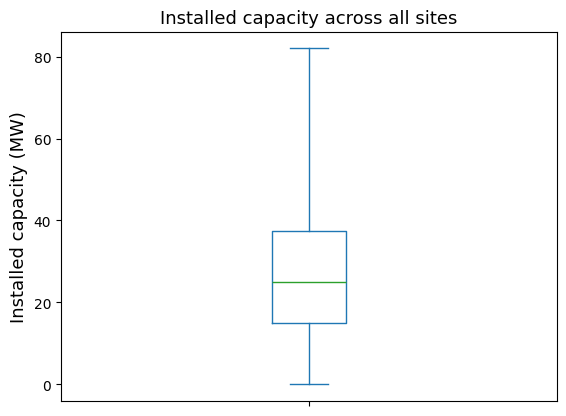

Average installed capacity by plant type:
    - cogeneration biomass: 26.1 MW
    - cogeneration other: 25.3 MW
    - cogeneration waste: 11.7 MW
    - hydro turbine pumped storage: 27.4 MW
    - hydro turbine reservoir: 23.1 MW
    - hydro turbine run of river: 24.4 MW
    - solar field canopy: 6.6 MW
    - solar field ground mounted: 23.2 MW
    - solar field rooftop: 15.8 MW
    - wind turbine offshore: 68.2 MW
    - wind turbine onshore: 41.9 MW


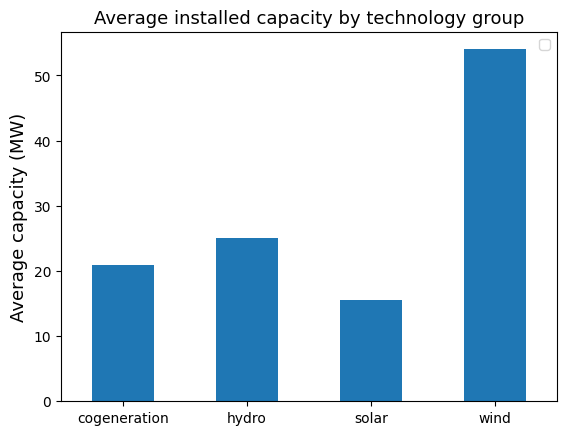

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Number of sites in the database
sites_number_query = sa.select(sa.func.count(m.Site.id))
number_of_sites = list(session.execute(sites_number_query).scalars())[0]
print(f"Total number of sites in the database: {number_of_sites}\n")


# Number of sites by technology type
sites_per_techno_query = sa.select(m.Site.techno, sa.func.count(m.Site.id)).group_by(
    m.Site.techno
)
sites_per_techno = list(session.execute(sites_per_techno_query))

print("Number of sites per plant type:")
for techno, num in sites_per_techno:
    print(f"    - {techno.replace("_", " ")}: {num}")


# Installed capacities for all sites
capacities_query = sa.select(m.Site.capacity)

capacities_df = pd.read_sql(capacities_query, engine)

ax = (capacities_df * 1e-3).plot(kind="box", whis=(0, 100))
ax.set_xticklabels([""])
plt.title("Installed capacity across all sites", fontsize=13)
plt.ylabel("Installed capacity (MW)", fontsize=13)
plt.show()


# Average capacity by technology type
capacity_by_techno_query = sa.select(
    m.Site.techno, sa.func.avg(m.Site.capacity)
).group_by(m.Site.techno)

capacity_by_techno = list(session.execute(capacity_by_techno_query))

print("Average installed capacity by plant type:")
for techno, capacity in capacity_by_techno:
    print(f"    - {techno.replace("_", " ")}: {capacity*1e-3:.1f} MW")


# Average capacity by technology "group" (hydro, wind, solar, cogeneration)
capacity_by_techno_group_query = sa.select(
    sa.func.substr(m.Site.techno, 1, sa.func.instr(m.Site.techno, "_") - 1).label(
        "techno_group"
    ),
    sa.func.avg(m.Site.capacity),
).group_by("techno_group")

capacity_by_group_df = pd.read_sql(capacity_by_techno_group_query, engine)
capacity_by_group_df.set_index("techno_group", inplace=True)
(capacity_by_group_df * 1e-3).plot(kind="bar", rot=0)
plt.xlabel("")
plt.legend("")
plt.title("Average installed capacity by technology group", fontsize=13)
plt.ylabel("Average capacity (MW)", fontsize=13)
plt.show()

### Question 2: 
Could you plot a map and tell in which coutries are all the sites ? 
Is there any pb with a site ?

In [5]:
# Retrieving the coordinates of all sites
coordinates_query = sa.select(m.Site.latitude, m.Site.longitude)
coordinates = pd.read_sql(coordinates_query, engine)

coordinates.head()

,latitude,longitude
0,43541958.0,-500187.0
1,44066139.0,2838912.0
2,45375451.0,-369294.0
3,43193215.0,963012.0
4,47900774.0,-1403181.0


The coordinates are not in degrees. Without more information about the unit/projection the data is in, let's try plotting them as they are using Bokeh (which uses Mercator projection).

In [6]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show

output_notebook()

x_range, y_range = (-15000000, 15000000), (-10000000, 10000000)

p = figure(
    x_range=x_range,
    y_range=y_range,
    x_axis_type="mercator",
    y_axis_type="mercator",
)
p.scatter(
    x=coordinates.longitude,
    y=coordinates.latitude,
    size=10,
)

p.add_tile("CartoDB Positron")

show(p)

Loading BokehJS ...

There seems to be a problem with the coordinates we plotted. Most of the sites are not visible on the map (and appear out of it when zooming out).

Using the appropriate projection and/or understanding possible problems in the coordinates values would be needed in order to be able to analyse the geographical distribution of the sites.

### Question 3:
- Get me sites that have timeseries configured. 
- which site has contract defined ?

In [8]:
sites_with_ts_query = sa.select(m.Site).where(m.Site.ts_records.any())
sites_with_ts = list(session.execute(sites_with_ts_query).scalars())

print("Sites with timeseries records:")
for site in sites_with_ts:
    print(repr(site))

Sites with timeseries records:
<Site n°14 - Energy for the Brave>
<Site n°15 - Reservoir Dogs Energy>
<Site n°97 - Village Solaire>
<Site n°98 - Barrage Mont Sunny>
<Site n°99 - Mont Venteux>


In [9]:
sites_with_contracts = sa.select(m.Site).where(m.Site.contracts.any())
sites_with_contracts = list(session.execute(sites_with_contracts).scalars())

print("Sites with contracts:")
for site in sites_with_contracts:
    print(repr(site))

Sites with contracts:
<Site n°1 - GigaWatt Llama Ranch>
<Site n°2 - Sunny Side of the Moon>
<Site n°3 - River Dance Powerhouse>
<Site n°4 - Turbine Nation Offshore>
<Site n°5 - Sunshine & Chill Canopy>
<Site n°6 - Watts in the Attic>
<Site n°7 - Flow like a River>
<Site n°8 - Juicy Biomass Co-op>
<Site n°9 - Offshore Avengers>
<Site n°10 - Trash into Cash>
<Site n°11 - Pumped Up Hydro>
<Site n°12 - Sunset Boulevard Energy>
<Site n°13 - Windy Wizards>
<Site n°14 - Energy for the Brave>
<Site n°15 - Reservoir Dogs Energy>
<Site n°97 - Village Solaire>
<Site n°98 - Barrage Mont Sunny>
<Site n°99 - Mont Venteux>


All sites that have timeseries records also have a contract.

### Question 4:
Focus on site with contracts

If you were to analyse the contracts, choose one that you would focus to leverage the most k€, why ?

Let's find the contract associated with the highest price:

In [11]:
# Contract with maximum price
max_contract_query = sa.select(m.Contract, sa.func.max(m.Contract.price))
max_contract = list(session.execute(max_contract_query))

contract, price = max_contract[0]

print("Contract with highest price:")
print(f"{repr(contract)}, price: {price}")

Contract with highest price:
<Contract n°13 - PO-6344-13>, price: 39100.0


For comparison, let's look at the prices of the other contracts:

In [13]:
contract_prices_query = sa.select(m.Contract, m.Contract.price).order_by(
    m.Contract.price.desc()
)
contract_prices = list(session.execute(contract_prices_query))

for contract, price in contract_prices:
    print(f"{repr(contract)}, price: {price}")

<Contract n°13 - PO-6344-13>, price: 39100.0
<Contract n°16 - PO-6789-16>, price: 791.0
<Contract n°17 - PO-1819-17>, price: 673.0
<Contract n°18 - PO-3347-18>, price: 528.0
<Contract n°2 - PO-9051-2>, price: 524.0
<Contract n°1 - PO-6713-1>, price: 511.0
<Contract n°3 - PO-8400-3>, price: 509.0
<Contract n°10 - PO-6990-10>, price: 506.0
<Contract n°8 - PO-5110-8>, price: 484.0
<Contract n°15 - PO-7417-15>, price: 465.0
<Contract n°7 - PO-9069-7>, price: 461.0
<Contract n°6 - PO-6137-6>, price: 453.0
<Contract n°5 - PO-7238-5>, price: 385.0
<Contract n°4 - PO-7646-4>, price: 381.0
<Contract n°9 - PO-6833-9>, price: 359.0
<Contract n°12 - PO-7784-12>, price: 338.0
<Contract n°11 - PO-4837-11>, price: 47.0
<Contract n°14 - PO-1619-14>, price: 39.0


### Question 5:
Timeseries : 
- Could you plot monthly production & financial report for the sites that have timeseries ?

In [14]:
ts_query = sa.select(m.TSRecords, m.Site.name).join(
    m.Site, m.TSRecords.site_id == m.Site.id
)

ts = pd.read_sql(ts_query, engine)

print(ts.unit_production.unique())
print(ts.unit_cashflow.unique())

['MWh' 'kWh']
['kEUR' 'EUR']


Let's put convert all production values to GWh and all cashflow values to M€.

In [15]:
ts.production = 1e-9 * ts.apply(
    lambda row: 1e6 * row.production
    if row.unit_production == "MWh"
    else 1e3 * row.production,
    axis=1,
)
ts.cashflow = 1e-6 * ts.apply(
    lambda row: 1e3 * row.cashflow if row.unit_cashflow == "kEUR" else row.cashflow,
    axis=1,
)

ts.drop(["unit_production", "unit_cashflow"], axis=1, inplace=True)

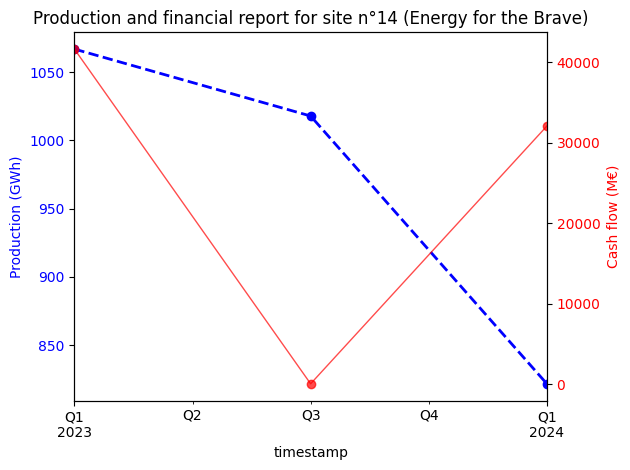

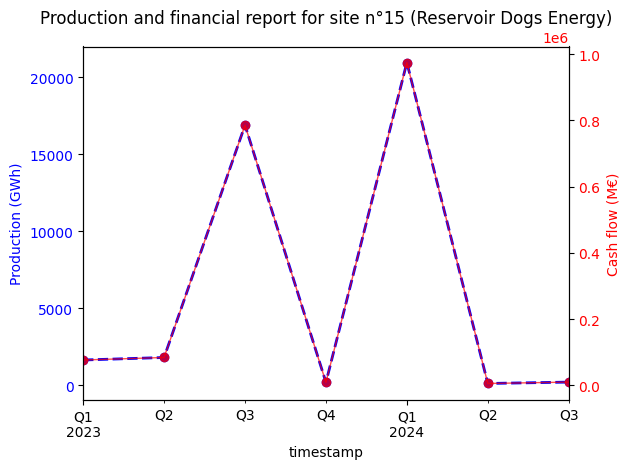

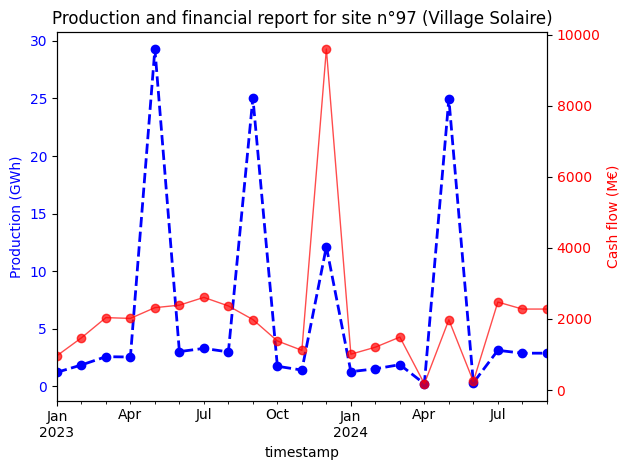

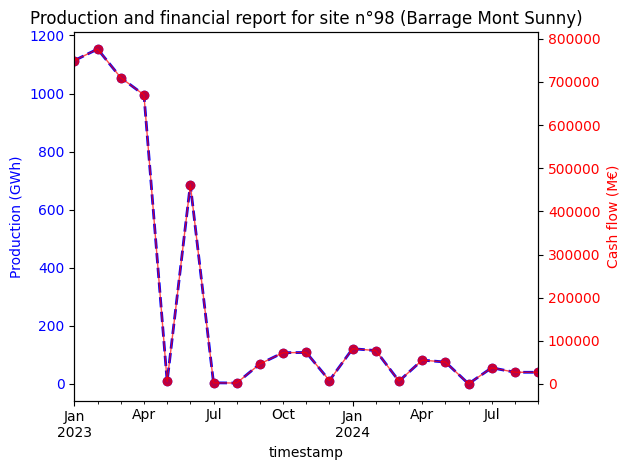

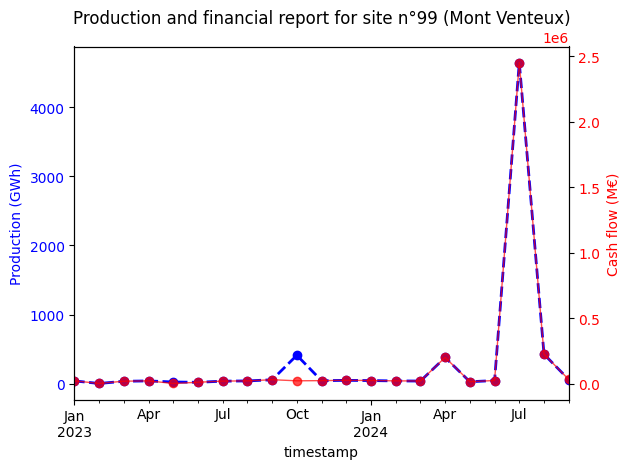

In [16]:
for id in ts.site_id.unique():
    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Time")
    ax1.set_ylabel("Production (GWh)", color="b")
    # ax1.plot(ts[ts.site_id == id].timestamp, ts[ts.site_id == id].production, color='b', marker='o', ls="--", linewidth=2)
    ts[ts.site_id == id].plot(
        x="timestamp",
        y="production",
        color="b",
        marker="o",
        ls="--",
        linewidth=2,
        ax=ax1,
    )
    ax1.tick_params(axis="y", labelcolor="b")
    ax1.legend().remove()

    ax2 = ax1.twinx()
    ax2.set_ylabel("Cash flow (M€)", color="r")
    # ax2.plot(ts[ts.site_id == id].timestamp, ts[ts.site_id == id].cashflow, color='r', marker='o', alpha=0.8)
    ts[ts.site_id == id].plot(
        x="timestamp",
        y="cashflow",
        color="r",
        marker="o",
        alpha=0.7,
        linewidth=1,
        ax=ax2,
    )
    ax2.tick_params(axis="y", labelcolor="r")
    ax2.legend().remove()

    plt.title(
        f"Production and financial report for site n°{id} ({ts[ts.site_id==id].name.iloc[0]})"
    )
    fig.tight_layout()
    plt.show()

Not all sites have records on a monthly timescale. Without more information or context, let's leave it at that.